### import thư viện

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns

from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D

### tổng quan dữ liệu

In [2]:
train_dataset = r"D:\TrafficSignRecognition_ComputerVision\data\Train"
data_dir = r"D:\TrafficSignRecognition_ComputerVision\data"
test_dataset = r"D:\TrafficSignRecognition_ComputerVision\data"

#Đường dẫn máy cường đừng xóa
# train_dataset = r".\data\Train"
# data_dir = r".\data"
# test_dataset = r".\data"

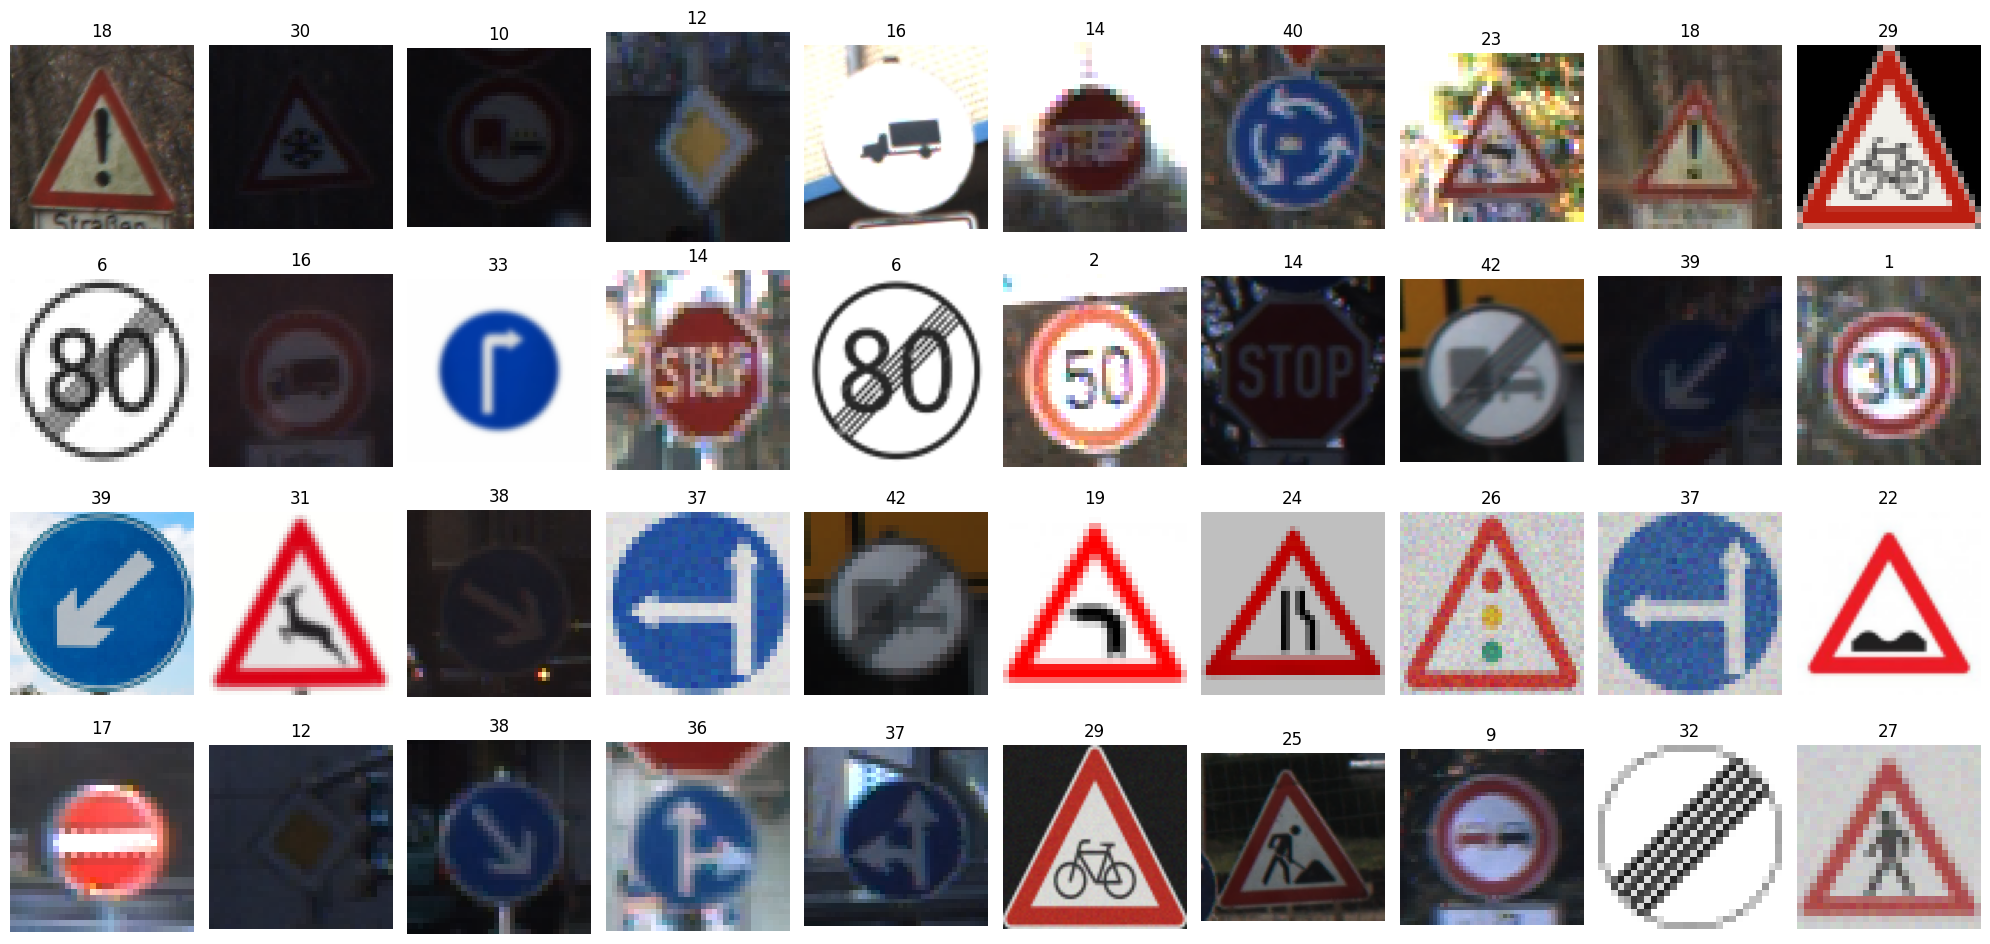

In [3]:
# Tạo danh sách chứa đường dẫn đến các tệp hình ảnh và nhãn của chúng
image_paths = []
labels = []

for class_folder in os.listdir(train_dataset):
    class_path = os.path.join(train_dataset, class_folder)
    for image_file in os.listdir(class_path):
        image_paths.append(os.path.join(class_path, image_file))
        labels.append(class_folder)  # Nhãn là tên thư mục lớp

# Tạo DataFrame từ danh sách
df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Chọn ngẫu nhiên số lượng hình ảnh để hiển thị
num_images_to_show = 40  # Bạn có thể thay đổi số lượng hình ảnh cần hiển thị
random_indices = np.random.choice(df.index, size=num_images_to_show, replace=False)
balanced_images = df.loc[random_indices]

# Hiển thị hình ảnh
fig, axes = plt.subplots(4, 10, figsize=(20, 10))
for i in range(4):
    for j in range(10):        
        image = cv2.imread(balanced_images.iloc[j + 10 * i]['image_path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Chuyển đổi màu sắc từ BGR sang RGB
        axes[i, j].imshow(image)
        axes[i, j].set_title(balanced_images.iloc[j + 10 * i]['label'])  
        axes[i, j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

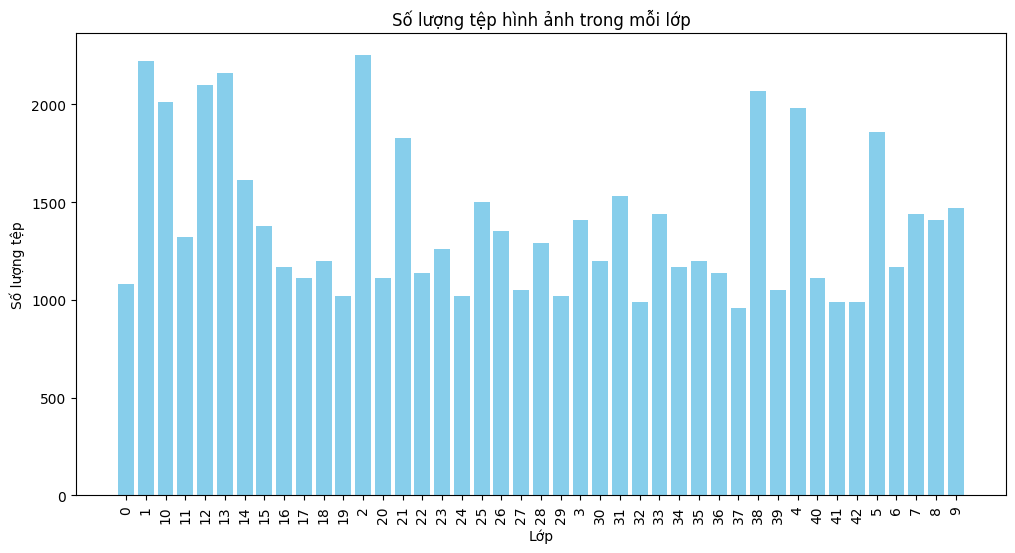

In [4]:
# Danh sách để lưu số lượng tệp trong mỗi lớp
file_counts = []

# Duyệt qua từng thư mục lớp trong train_dataset
for class_folder in os.listdir(train_dataset):
    class_path = os.path.join(train_dataset, class_folder)
    # Đếm số lượng tệp trong mỗi thư mục lớp
    num_files = len(os.listdir(class_path))
    file_counts.append(num_files)

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.bar(range(len(file_counts)), file_counts, color='skyblue')
plt.xticks(range(len(file_counts)), os.listdir(train_dataset), rotation=90)  # Xoay nhãn trên trục x
plt.title('Số lượng tệp hình ảnh trong mỗi lớp')
plt.xlabel('Lớp')
plt.ylabel('Số lượng tệp')
plt.show()

In [6]:
# Function to load and preprocess images
def load_images_from_directory(path, class_id, image_size=(30, 30)):
    images = os.listdir(path)
    data = []
    labels = []

    for image_filename in images:
        try:
            image = Image.open(os.path.join(path, image_filename))
            image = image.resize(image_size)
            image = np.array(image)
            data.append(image)
            labels.append(class_id)
        except Exception as e:
            print(f"Error loading image: {os.path.join(path, image_filename)} - {e}")

    return data, labels

# Retrieving the images and their labels
data = []
labels = []
num_classes = 43
current_path = os.getcwd()

for class_id in range(num_classes):
    path = os.path.join(current_path, 'data/Train', str(class_id))
    class_data, class_labels = load_images_from_directory(path, class_id)
    data.extend(class_data)
    labels.extend(class_labels)

# Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

print(data.shape, labels.shape)

# Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Converting the labels into one hot encoding
y_train_one_hot = to_categorical(y_train, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)

# Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))

# Replace the Flatten layer with GlobalAveragePooling2D
model.add(GlobalAveragePooling2D())

# Optionally, you can add more Dense layers with BatchNormalization and Dropout
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))

# Make sure num_classes is defined properly for your specific problem
model.add(Dense(num_classes, activation='softmax'))

# Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 15
history = model.fit(X_train, y_train_one_hot, batch_size=32, epochs=epochs, validation_data=(X_test, y_test_one_hot))

# Save the model
model.save("model_tt.h5")

(59783, 30, 30, 3) (59783,)
(47826, 30, 30, 3) (11957, 30, 30, 3) (47826,) (11957,)


d:\APP\python\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.5017 - loss: 1.9732 - val_accuracy: 0.9460 - val_loss: 0.1896
Epoch 2/15
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.9433 - loss: 0.1874 - val_accuracy: 0.9832 - val_loss: 0.0584
Epoch 3/15
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step - accuracy: 0.9691 - loss: 0.1044 - val_accuracy: 0.9958 - val_loss: 0.0167
Epoch 4/15
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.9761 - loss: 0.0809 - val_accuracy: 0.9908 - val_loss: 0.0296
Epoch 5/15
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.9800 - loss: 0.0641 - val_accuracy: 0.9962 - val_loss: 0.0140
Epoch 6/15
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.9843 - loss: 0.0524 - val_accuracy: 0.9868 - val_loss: 0.0447
Epoch 7/15
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.9846 - loss: 0.0521 - val_accuracy: 0.9973 - val_loss: 0.0104
Epoch 8/15
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step - accuracy: 0.9872 -

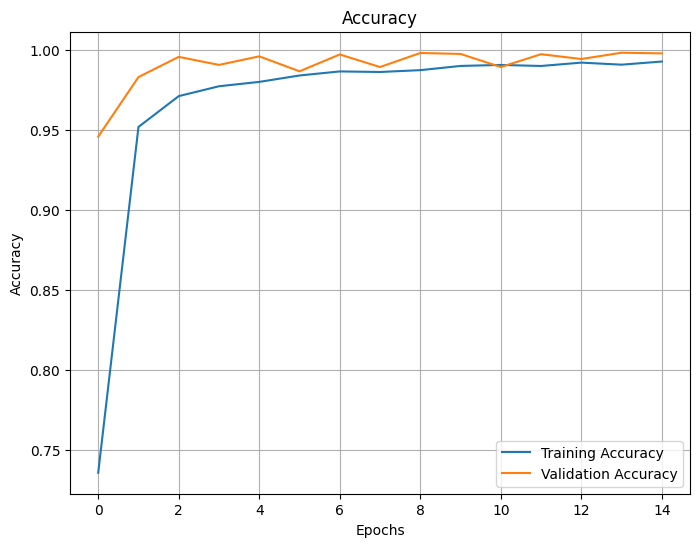

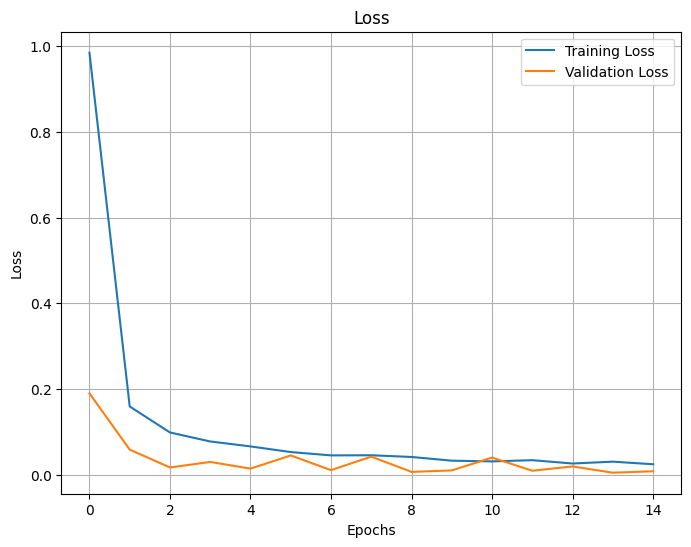

In [8]:
def plot_accuracy(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting graphs for accuracy and loss
plot_accuracy(history)
plot_loss(history)


In [9]:
#testing accuracy on test dataset
from sklearn.metrics import accuracy_score
import pandas as pd

y_test = pd.read_csv('data/Test.csv')

labels = y_test["ClassId"].values
imgs = y_test["Path"].values
data=[]

for img in imgs:
    image = Image.open("data/"+img)
    image = image.resize((30,30))
    data.append(np.array(image))

X_test=np.array(data)

# Make predictions on the test data
pred_probs = model.predict(X_test)
pred = np.argmax(pred_probs, axis=1)

#Accuracy with the test data
from sklearn.metrics import accuracy_score
print(accuracy_score(labels, pred))

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
0.9679334916864608


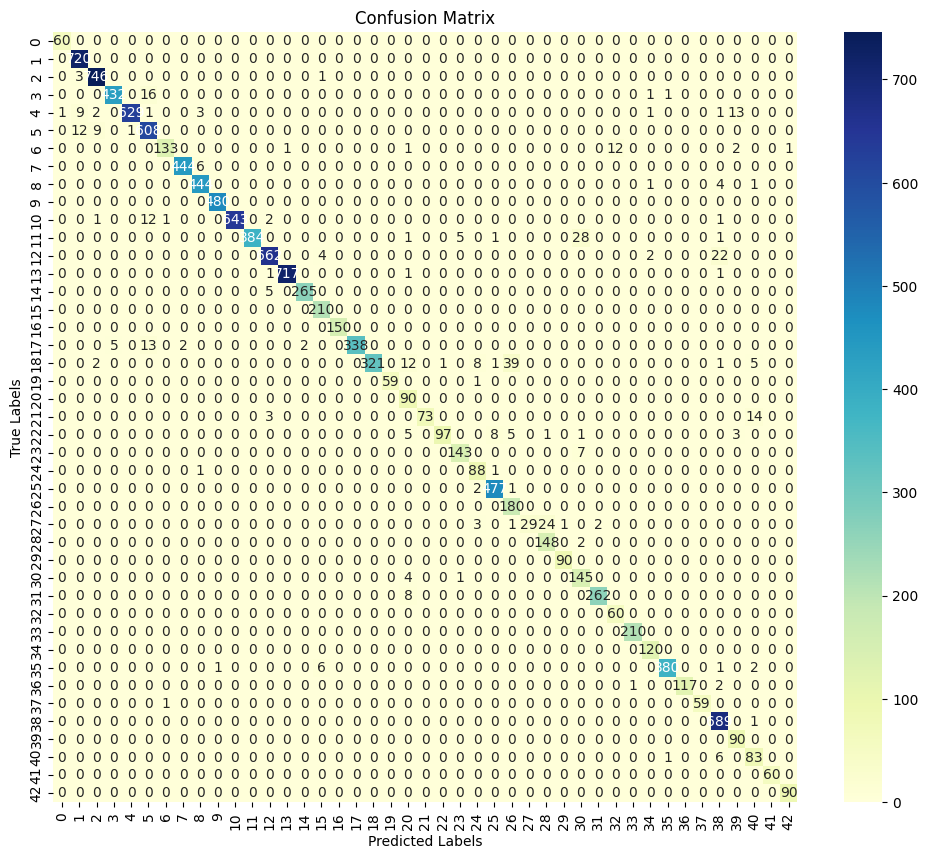

In [10]:
# Compute the confusion matrix
cm = confusion_matrix(labels, pred)

# Plotting the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Lớp 4:


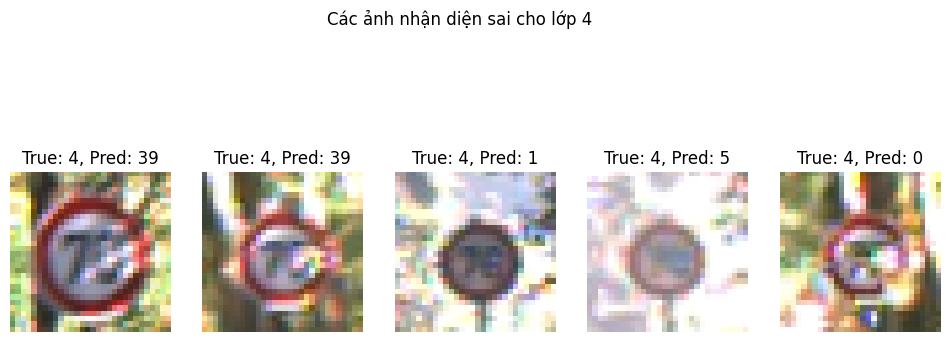


Lớp 5:


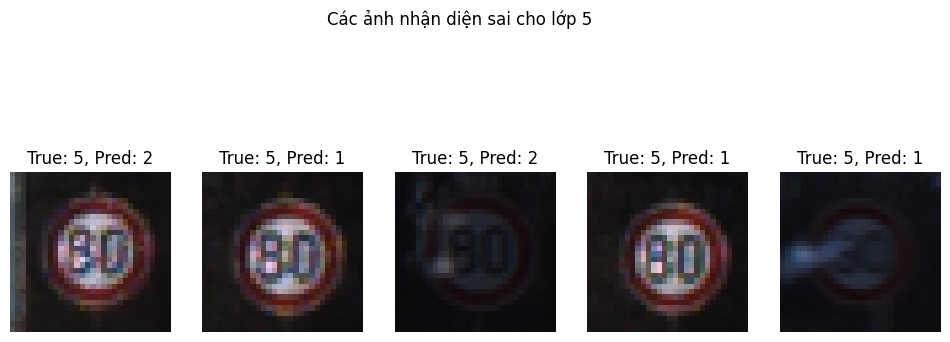


Lớp 6:


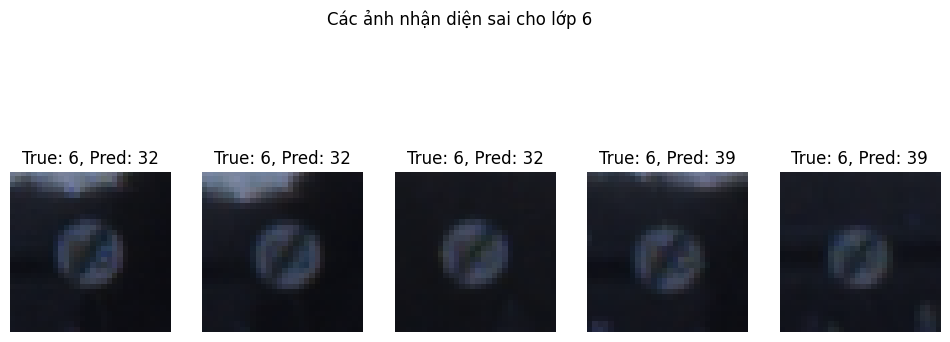


Lớp 10:


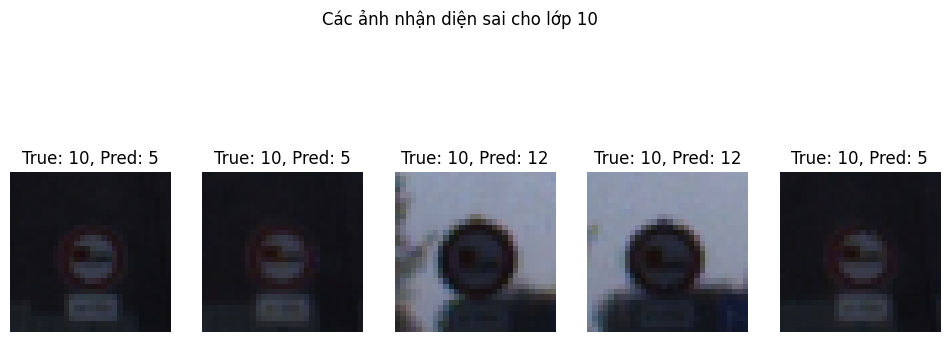


Lớp 11:


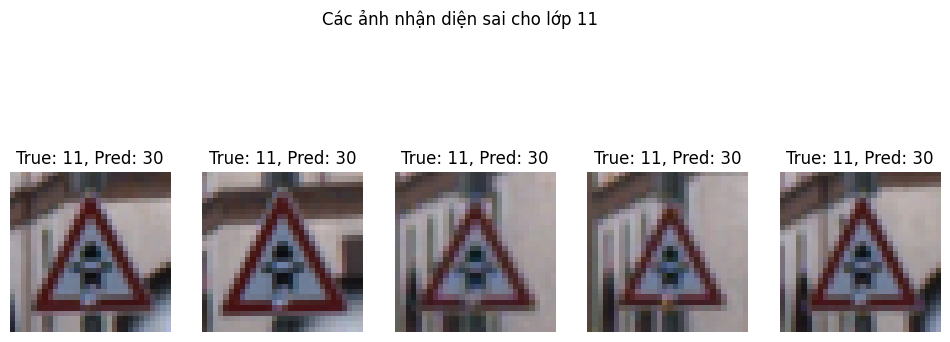


Lớp 12:


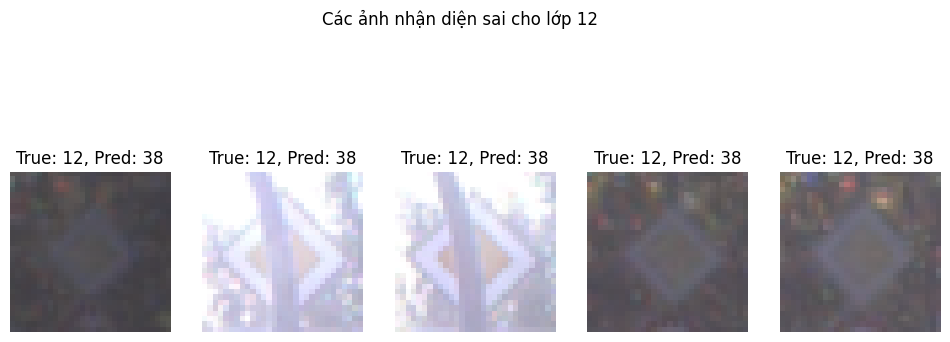


Lớp 17:


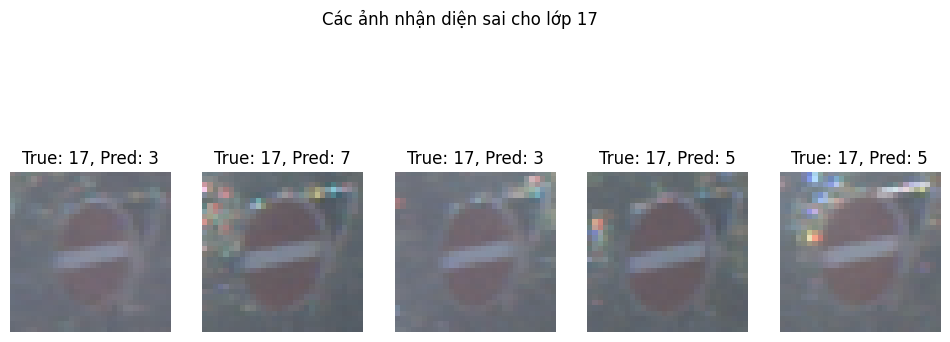


Lớp 18:


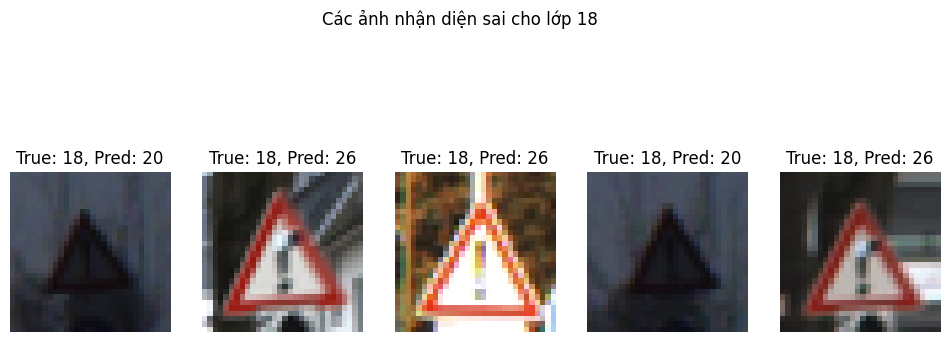


Lớp 21:


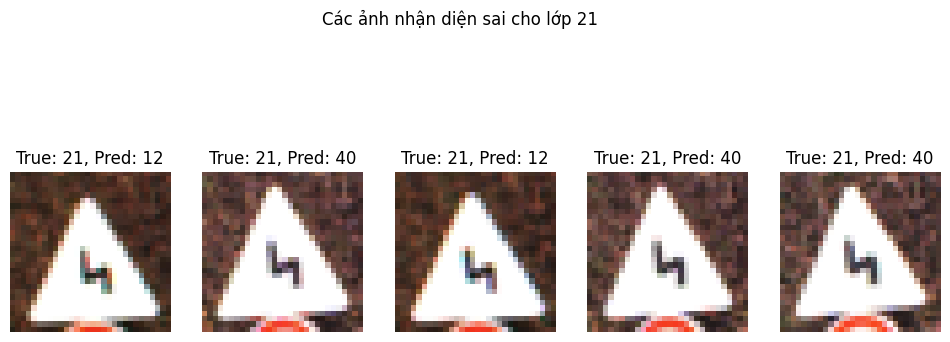

In [20]:
# Các lớp cần hiển thị
target_classes = [4, 5, 6, 10, 11, 12, 17, 18, 21]

# Tạo một danh sách để lưu trữ các chỉ số ảnh nhận diện sai cho các lớp mục tiêu
misclassified_indices = {}

# Tìm các chỉ số dự đoán sai cho từng lớp mục tiêu
for class_id in target_classes:
    misclassified_indices[class_id] = np.where((pred != labels) & (labels == class_id))[0]

# Hiển thị 5 ảnh nhận diện sai cho từng lớp mục tiêu
for class_id in target_classes:
    indices = misclassified_indices[class_id]
    num_to_display = min(5, len(indices))  # Hiển thị tối đa 5 ảnh, nếu có

    print(f"\nLớp {class_id}:")
    plt.figure(figsize=(12, 5))  # Điều chỉnh kích thước figure

    for i in range(num_to_display):
        plt.subplot(1, 5, i + 1)  # Tạo 1 dòng 5 ảnh
        plt.imshow(X_test[indices[i]])  # Hiển thị ảnh gốc
        plt.title(f"True: {labels[indices[i]]}, Pred: {pred[indices[i]]}")
        plt.axis('off')

    plt.suptitle(f"Các ảnh nhận diện sai cho lớp {class_id}")
    plt.show()
